# Scavenge Agent demo

This notebook shows the `ScavengeAgent` functionality. This agent extends the `ForageAgent` and allows it to in addition to consume objects, it can also pick and drop objects in its environment.

In [6]:
%load_ext autoreload
%autoreload 2

import sys

if ".." not in sys.path:
    sys.path.append("..")
                    
import numpy as np
np.random.seed(1337)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Environment

We use a simple environment of 5 nodes.

In [7]:
import util
from envs import GraphEnv

graph, metadata = util.generate_line(5)

agent_config = {
        "Scavenger": 2,
    }
# define objects and their true locations
object_config = {"Food": 4}

# create environment
env = GraphEnv(graph, agent_config, object_config)

## Agents

Now we create a `ScavengeAgent`.

In [8]:
from agents import ScavengeAgent

agent = ScavengeAgent("Scavenger", env, [0])

## Simulation

We run the simulation for 40 timesteps. The agent should forage for food and consume it, in order to get its energy levels up.

In [9]:
from experiment import tick

result = {a: [] for a in agent_config.keys()}

# simulate T timesteps
T = 20
for t in range(T):
    info = tick(agent, env)
    for a, info in info.items():
        result[a].append(info)

Scavenger picks object
Scavenger moved to location 3
Scavenger moved to location 4 and observed object
Object consumed, respawned at location  4
Scavenger eats
Object picked
Scavenger picks object
Object dropped
Scavenger drops object
Object consumed, respawned at location  1
Scavenger eats
Scavenger moved to location 3
Scavenger moved to location 2
Scavenger moved to location 1 and observed object
Object consumed, respawned at location  3
Scavenger eats
Scavenger moved to location 0
Scavenger drops object
Scavenger moved to location 1
Scavenger moved to location 2
Scavenger moved to location 3 and observed object
Object consumed, respawned at location  4
Scavenger eats
Scavenger moved to location 4 and observed object
Object consumed, respawned at location  2
Scavenger eats
Scavenger moved to location 3


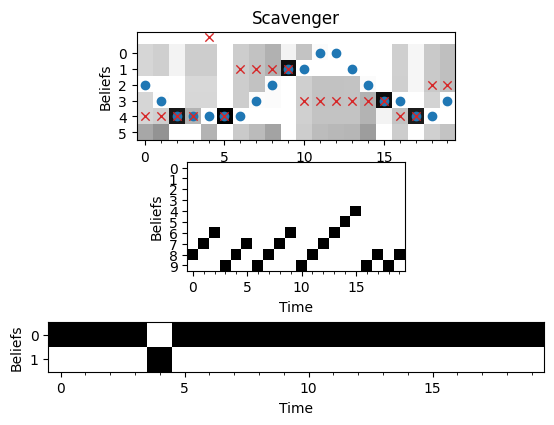

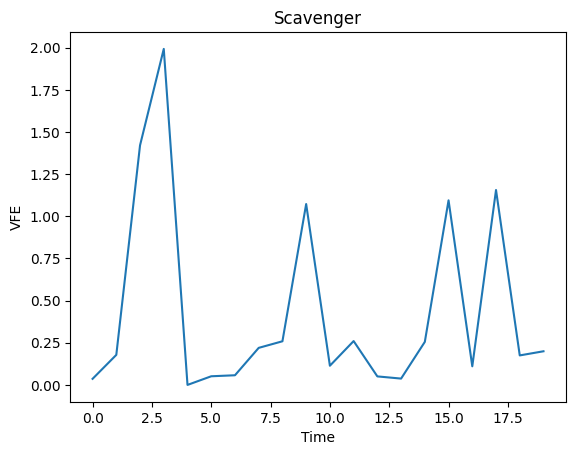

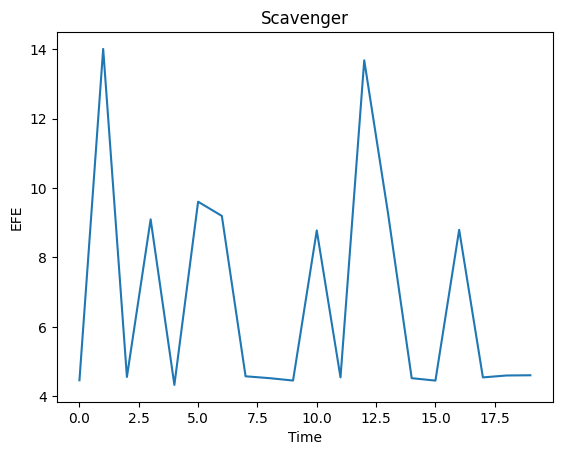

In [10]:
from visualize import *

plot_beliefs(result)
plot_vfe(result)
plot_efe(result)

Notice that our Scavenger also forages for food. There is only a dispreferred state to have 0 energy. Weirdly enough, at time 3 it immediately eats, although it is not yet "hungry", and at time 5 it first picks the object, then drops it again to eat it. Why is that so?

Visualizing the plan tree at time 16, we can see that it actually eats because it expects new food to respawn thereafter. So it effectively eats in anticipation of future information gain searching the new food again. So funny enough our foragers eat out of curiosity instead of out of hunger.

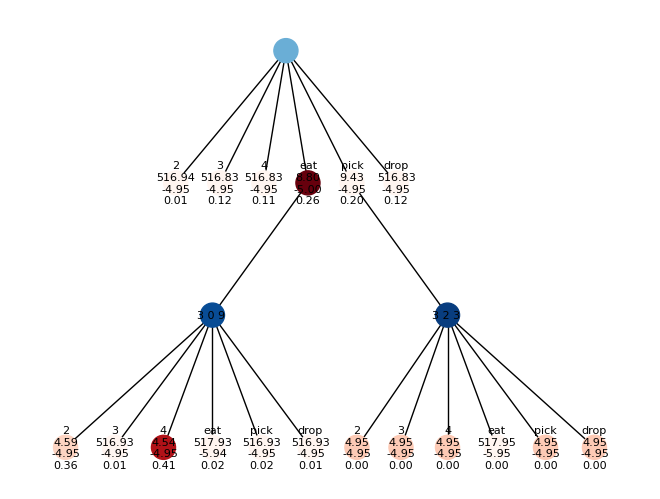

In [12]:
timestep = 16
plan_tree = result["Scavenger"][timestep]["tree"]


def policy_label(node):
    policy = node["policy"]
    res = ""
    if policy[0][1] == 1:
        res = "eat"
    elif policy[0][1] == 2:
        res = "pick"
    elif policy[0][1] == 3:
        res = "drop"
    else:
        res = str(policy[0][0])
    res = (
        res
        + "\n{:.2f}".format(node["G"])
        + "\n{:.2f}".format(node["EU"])
        + "\n{:.2f}".format(node["EIG"])
    )
    return res


def observation_label(node):
    observation = node["observation"]
    res = ""
    for i, o in enumerate(observation):
        res += str(np.argmax(o)) + " "
    return res


plot_plan_tree(plan_tree, policy_label, observation_label, font_size=8, depth=1)

So why does it pick up the food at timestep 4? Well, the environment randomly respawns the object at the same location. However, the agent has a prior that the food would respawn _somewhere else_. Therefore, it has still some uncertainty about whether the food is actually legit food. The way to find out without risking getting sick is to first pick up the food and see if it gets in the inventory, and then drop it again and safely eat it.

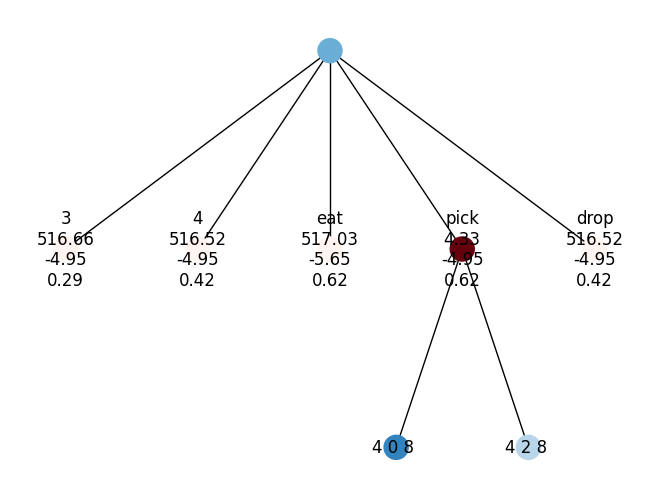

In [14]:
timestep = 4
plan_tree = result["Scavenger"][timestep]["tree"]
plot_plan_tree(plan_tree, policy_label, observation_label)